In [1]:
import random; from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def decor_header(params):
    params=params.split('|'); string=params[0]
    if len(params)==1: 
        font_size='24'; font_family='Wallpoet'; cmap='Sinebow'
    elif  len(params)==2: 
        font_size=params[1]
        font_family='Wallpoet'; cmap='Sinebow'
    elif  len(params)==3: 
        font_size=params[1]; font_family=params[2]
        cmap='Sinebow'
    else: 
        font_size=params[1]; font_family=params[2]; cmap=params[3]
    height=max([int(font_size)*2.5,60]) 
    html_str="""
<script src='https://d3js.org/d3.v6.min.js'></script>
<style>
@import 'https://fonts.googleapis.com/css?family="""+font_family+"""';
#colorized001 {
font-family:"""+font_family+"""; font-size:"""+font_size+""";}
#canvas001,#canvas002 {width:10%; vertical-align:middle;}
</style>
<text id='colorized001'><canvas id='canvas001'></canvas>
"""+string+"""
<canvas id='canvas002'></canvas></text><br/>
<script>
var tc=setInterval(function() {
    var now=(new Date().getTime()%5000)/5000;
    var now_slow=(new Date().getTime()%100000)/100000;
    var iddoc=document.getElementById('colorized001');
    iddoc.style.color=d3.interpolate"""+cmap+"""(now);
    var r=10,n=7;
    var c1=document.getElementById('canvas001'); 
    var context1=c1.getContext('2d');
    var c2=document.getElementById('canvas002'); 
    var context2=c2.getContext('2d');
    c1.style.background=d3.interpolate"""+cmap+"""(now_slow); 
    c2.style.background=d3.interpolate"""+cmap+"""(now_slow);
    context1.strokeStyle=d3.interpolate"""+cmap+"""(now);    
    context2.strokeStyle=d3.interpolate"""+cmap+"""(now);
    for (var i=1; i<n; i++) {
        context1.beginPath(); context2.beginPath();
        for (var j=0; j<6; j++) {
            context1.arc(60*j,r*(n+.5),i*r,0,2*Math.PI);
            context2.arc(60*j,r*(n+.5),i*r,0,2*Math.PI); };
        context1.stroke(); context2.stroke(); }; },1)
</script>"""
    display(HTML(html_str))

In [2]:
%decor_header Modules, Helpful Functions, & Styling

In [3]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import tensorflow_hub as th
import seaborn as sn,zipfile,h5py,urllib
import tensorflow as tf,keras as ks
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import PIL.Image

In [4]:
data_path='https://raw.githubusercontent.com/'+\
          'OlgaBelitskaya/data_kitchen/main/'
file_path='https://olgabelitskaya.gitlab.io/images/'
tfhub_path='https://tfhub.dev/google/magenta/'+\
           'arbitrary-image-stylization-v1-256/1'
model_weights='weights.best.flowers.hdf5'
model_weights2='weights.best.cifar.hdf5'

In [5]:
def prepro(x_train,y_train,x_test,y_test):
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]

In [6]:
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,verbose=int(0),
                     save_weights_only=True,save_best_only=True,
                     monitor='val_accuracy',mode='max')
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [7]:
def load_img(path_to_img):
    max_dim=512
    img=tf.io.read_file(path_to_img)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim=max(shape)
    scale=max_dim/long_dim
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    img=img[tf.newaxis,:]
    return img
def tensor_to_image(tensor):
    tensor=tensor*255
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

In [8]:
%decor_header Data Loading & Preprocessing

In [9]:
zf='Flowers128.h5'
input_file=urllib.request.urlopen(data_path+zf)
output_file=open(zf,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
with h5py.File(zf,'r') as f:
    keys=list(f.keys())
    print('h5py.File keys: '+', '.join(keys))
    images=np.array(f[keys[0]])
    labels=np.array(f[keys[1]])
    names=[el.decode('utf-8')for el in f[keys[2]]]
    f.close()

h5py.File keys: images, labels, names


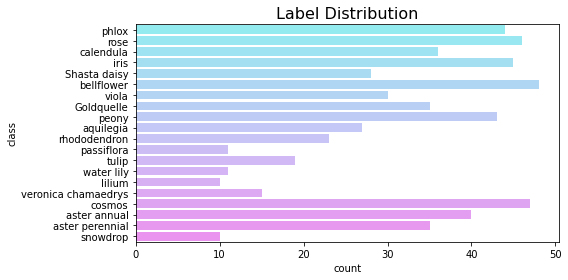

In [10]:
df=pd.DataFrame(labels,columns=['label'])
df['class']=[names[l] for l in labels]
pl.figure(figsize=(8,4))
sn.countplot(y='class',data=df,palette='cool',alpha=.5)
ti='Label Distribution'
pl.title(ti,fontsize=16); pl.tight_layout(); pl.show()

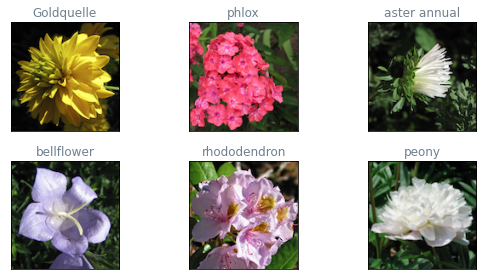

,train,valid,test
image shape,"(483, 128, 128, 3)","(60, 128, 128, 3)","(60, 128, 128, 3)"
image type,float32,float32,float32
label shape,"(483,)","(60,)","(60,)"
label type,int32,int32,int32


In [11]:
N=labels.shape[0]; n=int(.1*N); shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
fig=pl.figure(figsize=(8,4)); n=np.random.randint(1,100)
for i in range(n,n+6):
    ax=fig.add_subplot(2,3,i-n+1,xticks=[],yticks=[])
    ax.set_title(
        names[labels[i]],color='slategray',
        fontdict={'fontsize':'large'})
    ax.imshow((images[i]))
pl.tight_layout(); pl.show(); display(df)

In [12]:
(x_train2,y_train2),(x_test2,y_test2)=\
ks.datasets.cifar10.load_data()
[[x_train2,x_valid2,x_test2],
 [y_train2,y_valid2,y_test2]]=\
prepro(x_train2,y_train2,x_test2,y_test2)

,train,valid,test
images,"(50000, 32, 32, 3)","(5000, 32, 32, 3)","(5000, 32, 32, 3)"
labels,"(50000, 1)","(5000, 1)","(5000, 1)"


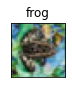

In [13]:
cifar_labels=['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']
pl.figure(figsize=(1,1)) 
pl.xticks([]); pl.yticks([])
pl.title(cifar_labels[y_train2[200][0]])
pl.imshow(x_train2[200]);

In [14]:
%decor_header Fast Examples

In [15]:
def get_file(file,file_path=file_path):
    input_file=urllib.request.urlopen(file_path+file)
    output_file=open(file,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
get_file('06_001.png')

('crane', 0.149169)
('lakeside', 0.11947846)
('pirate', 0.07267871)
('missile', 0.05283804)
('wreck', 0.04948564)


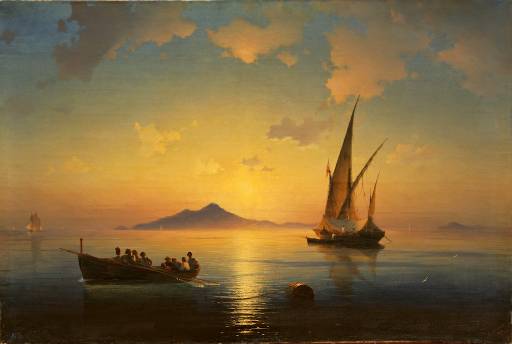

In [16]:
content_image=load_img('06_001.png')
x=tf.keras.applications.vgg19\
.preprocess_input(content_image*255)
x=tf.image.resize(x,(224,224))
vgg19=tf.keras.applications\
.VGG19(include_top=True,weights='imagenet')
prediction_probabilities=vgg19(x)
predicted_top5=tf.keras.applications.vgg19\
.decode_predictions(prediction_probabilities.numpy())[0]
[print((class_name,prob)) 
 for (number,class_name,prob) in predicted_top5]
tensor_to_image(content_image)

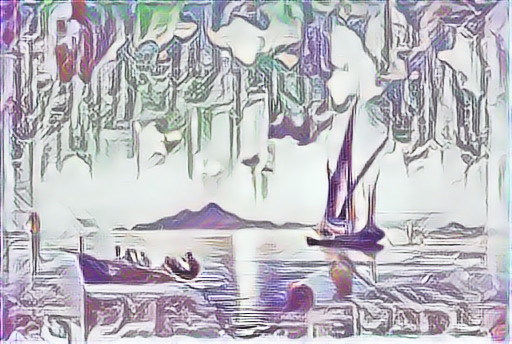

In [17]:
hub_module=th.load(tfhub_path)
get_file('06_001.png')
get_file('02_018.png')
content_image=load_img('06_001.png')
style_image=load_img('02_018.png')
stylized_image=hub_module(
    tf.constant(content_image),
    tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [18]:
%decor_header Keras Models

In [19]:
def mlp_model(img_size,num_classes):
    model=tf.keras.models.Sequential([
        tf.keras.layers.Flatten(
            input_shape=(img_size,img_size,3)),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(num_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
model=mlp_model(128,20)
model.fit(x_train,y_train,epochs=100,batch_size=16,
          callbacks=cb(model_weights),
          validation_data=(x_valid,y_valid));

Epoch 1/100
31/31 [==============================] - 1s 20ms/step - loss: 2.9680 - accuracy: 0.2075 - val_loss: 8.5580 - val_accuracy: 0.1333
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 1.8684 - accuracy: 0.4418 - val_loss: 6.3980 - val_accuracy: 0.0667
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 1.4718 - accuracy: 0.5683 - val_loss: 4.1963 - val_accuracy: 0.1167
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 1.1432 - accuracy: 0.6382 - val_loss: 4.1900 - val_accuracy: 0.2000
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.9079 - accuracy: 0.7195 - val_loss: 3.7750 - val_accuracy: 0.1167
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.7828 - accuracy: 0.7959 - val_loss: 3.1321 - val_accuracy: 0.2000
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 0.7184 - accuracy: 0.7600 - val_loss: 3.1228 - val_accuracy: 0.2333
Epoch 8/100


In [21]:
model.load_weights(model_weights)
model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 6ms/step - loss: 2.7597 - accuracy: 0.4667


[2.7597060203552246, 0.46666666865348816]

In [22]:
model=mlp_model(32,10)
model.fit(x_train2,y_train2,epochs=100,batch_size=16,
          validation_data=(x_valid2,y_valid2),
          callbacks=cb(model_weights2))

Epoch 1/100
3125/3125 [==============================] - 11s 3ms/step - loss: 2.1553 - accuracy: 0.2873 - val_loss: 1.7798 - val_accuracy: 0.3842
Epoch 2/100
3125/3125 [==============================] - 10s 3ms/step - loss: 1.7042 - accuracy: 0.3911 - val_loss: 1.9762 - val_accuracy: 0.4148
Epoch 3/100
3125/3125 [==============================] - 10s 3ms/step - loss: 1.6587 - accuracy: 0.4133 - val_loss: 1.9214 - val_accuracy: 0.4222
Epoch 4/100
3125/3125 [==============================] - 10s 3ms/step - loss: 1.5949 - accuracy: 0.4311 - val_loss: 1.6083 - val_accuracy: 0.4350
Epoch 5/100
3125/3125 [==============================] - 10s 3ms/step - loss: 1.5590 - accuracy: 0.4418 - val_loss: 2.0096 - val_accuracy: 0.4320
Epoch 6/100
3125/3125 [==============================] - 9s 3ms/step - loss: 1.5483 - accuracy: 0.4488 - val_loss: 1.6883 - val_accuracy: 0.4876
Epoch 7/100
3125/3125 [==============================] - 10s 3ms/step - loss: 1.5040 - accuracy: 0.4653 - val_loss: 4.2474 - 

In [23]:
model.load_weights(model_weights2)
model.evaluate(x_test2,y_test2)

157/157 [==============================] - 0s 2ms/step - loss: 3.6071 - accuracy: 0.5094


[3.607114553451538, 0.5094000101089478]

In [24]:
def cnn_model(img_size,num_classes):
    model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(
            32,(5,5),padding='same',
            input_shape=(img_size,img_size,3)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Conv2D(196,(5,5)),
        tf.keras.layers.Activation('relu'),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.GlobalAveragePooling2D(),    
        tf.keras.layers.Dense(512),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(num_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [25]:
model=cnn_model(128,20)
model.fit(x_train,y_train,epochs=100,batch_size=64,
          validation_data=(x_valid,y_valid),
          callbacks=cb(model_weights))

Epoch 1/100
8/8 [==============================] - 2s 140ms/step - loss: 2.9984 - accuracy: 0.0323 - val_loss: 2.9760 - val_accuracy: 0.0333
Epoch 2/100
8/8 [==============================] - 1s 64ms/step - loss: 2.9393 - accuracy: 0.0727 - val_loss: 2.9851 - val_accuracy: 0.1000
Epoch 3/100
8/8 [==============================] - 0s 63ms/step - loss: 2.9032 - accuracy: 0.0763 - val_loss: 2.9524 - val_accuracy: 0.1667
Epoch 4/100
8/8 [==============================] - 1s 64ms/step - loss: 2.8687 - accuracy: 0.1142 - val_loss: 2.8531 - val_accuracy: 0.2167
Epoch 5/100
8/8 [==============================] - 0s 63ms/step - loss: 2.7284 - accuracy: 0.1344 - val_loss: 2.7273 - val_accuracy: 0.2000
Epoch 6/100
8/8 [==============================] - 1s 64ms/step - loss: 2.5812 - accuracy: 0.2118 - val_loss: 2.6239 - val_accuracy: 0.2167
Epoch 7/100
8/8 [==============================] - 1s 64ms/step - loss: 2.4680 - accuracy: 0.2026 - val_loss: 2.5340 - val_accuracy: 0.2000
Epoch 8/100
8/8 [==

In [26]:
model.load_weights(model_weights)
model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 88ms/step - loss: 1.3465 - accuracy: 0.6333


[1.3465023040771484, 0.6333333253860474]

In [27]:
model=cnn_model(32,10)
model.fit(x_train2,y_train2,epochs=100,batch_size=64,
          validation_data=(x_valid2,y_valid2),
          callbacks=cb(model_weights2))

Epoch 1/100
782/782 [==============================] - 5s 6ms/step - loss: 3.0068 - accuracy: 0.2307 - val_loss: 1.5813 - val_accuracy: 0.4136
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - loss: 1.5833 - accuracy: 0.4151 - val_loss: 1.4048 - val_accuracy: 0.5082
Epoch 3/100
782/782 [==============================] - 4s 5ms/step - loss: 1.4407 - accuracy: 0.4795 - val_loss: 1.3111 - val_accuracy: 0.5386
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - loss: 1.3471 - accuracy: 0.5175 - val_loss: 1.2373 - val_accuracy: 0.5540
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - loss: 1.2938 - accuracy: 0.5412 - val_loss: 1.1787 - val_accuracy: 0.5822
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: 1.2285 - accuracy: 0.5593 - val_loss: 1.1193 - val_accuracy: 0.6150
Epoch 7/100
782/782 [==============================] - 4s 5ms/step - loss: 1.1950 - accuracy: 0.5721 - val_loss: 1.0867 - val_accuracy: 0.6064

In [28]:
model.load_weights(model_weights2)
model.evaluate(x_test2,y_test2)

157/157 [==============================] - 0s 2ms/step - loss: 0.7499 - accuracy: 0.7726


[0.7498737573623657, 0.772599995136261]

In [44]:
def rnn_model(img_size,hidden,num_classes):
    model=tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(
            input_shape=(1,3*img_size**2)),
        tf.keras.layers.LSTM(hidden,return_sequences=True),
        tf.keras.layers.LSTM(hidden,return_sequences=True),
        tf.keras.layers.LSTM(hidden),
        tf.keras.layers.BatchNormalization(),     
        tf.keras.layers.Dense(num_classes,activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])    
    return model 

In [45]:
model=rnn_model(128,256,20)
model.fit(x_train.reshape(-1,1,128*128*3),y_train,
          epochs=100,batch_size=128,callbacks=cb(model_weights),
          validation_data=(x_valid.reshape(-1,1,128*128*3),y_valid))

Epoch 1/100
4/4 [==============================] - 5s 440ms/step - loss: 2.8066 - accuracy: 0.1239 - val_loss: 2.9769 - val_accuracy: 0.1500
Epoch 2/100
4/4 [==============================] - 0s 59ms/step - loss: 1.5794 - accuracy: 0.5676 - val_loss: 2.9630 - val_accuracy: 0.1000
Epoch 3/100
4/4 [==============================] - 0s 57ms/step - loss: 1.0178 - accuracy: 0.7801 - val_loss: 2.9537 - val_accuracy: 0.1000
Epoch 4/100
4/4 [==============================] - 0s 57ms/step - loss: 0.7361 - accuracy: 0.8219 - val_loss: 2.9476 - val_accuracy: 0.0667
Epoch 5/100
4/4 [==============================] - 0s 56ms/step - loss: 0.4190 - accuracy: 0.9326 - val_loss: 2.9460 - val_accuracy: 0.0833
Epoch 6/100
4/4 [==============================] - 0s 56ms/step - loss: 0.2637 - accuracy: 0.9720 - val_loss: 2.9410 - val_accuracy: 0.0833
Epoch 7/100
4/4 [==============================] - 0s 57ms/step - loss: 0.1625 - accuracy: 0.9835 - val_loss: 2.9356 - val_accuracy: 0.1000
Epoch 8/100
4/4 [==

In [46]:
model.load_weights(model_weights)
model.evaluate(x_test.reshape(-1,1,128*128*3),y_test)

2/2 [==============================] - 0s 14ms/step - loss: 2.0221 - accuracy: 0.4500


[2.022130012512207, 0.44999998807907104]

In [47]:
model=rnn_model(32,128,10)
model.fit(x_train2.reshape(-1,1,32*32*3),y_train2,
          epochs=50,batch_size=128,callbacks=cb(model_weights2),
          validation_data=(x_valid2.reshape(-1,1,32*32*3),y_valid2))

Epoch 1/50
391/391 [==============================] - 7s 9ms/step - loss: 1.7894 - accuracy: 0.3570 - val_loss: 1.9671 - val_accuracy: 0.3918
Epoch 2/50
391/391 [==============================] - 3s 7ms/step - loss: 1.5675 - accuracy: 0.4382 - val_loss: 1.5695 - val_accuracy: 0.4394
Epoch 3/50
391/391 [==============================] - 3s 7ms/step - loss: 1.5029 - accuracy: 0.4628 - val_loss: 1.5075 - val_accuracy: 0.4642
Epoch 4/50
391/391 [==============================] - 3s 7ms/step - loss: 1.4494 - accuracy: 0.4791 - val_loss: 1.4974 - val_accuracy: 0.4576
Epoch 5/50
391/391 [==============================] - 3s 7ms/step - loss: 1.4069 - accuracy: 0.4977 - val_loss: 1.4875 - val_accuracy: 0.4676
Epoch 6/50
391/391 [==============================] - 3s 7ms/step - loss: 1.3627 - accuracy: 0.5102 - val_loss: 1.4805 - val_accuracy: 0.4710
Epoch 7/50
391/391 [==============================] - 3s 7ms/step - loss: 1.3352 - accuracy: 0.5237 - val_loss: 1.4590 - val_accuracy: 0.4896
Epoch 

In [49]:
model.load_weights(model_weights2)
model.evaluate(x_test2.reshape(-1,1,32*32*3),y_test2)

157/157 [==============================] - 0s 3ms/step - loss: 1.5019 - accuracy: 0.4982


[1.5018768310546875, 0.498199999332428]